In [27]:
!pip install ipywidgets==7.0.0 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.


In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [29]:
model_id, model_version = "model-txt2img-stabilityai-stable-diffusion-v2", "*"

In [30]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = "stablediffusion-txt2img-v2"

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE":'20000000',
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env = env,
)

# # deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# # for being able to run inference through the sagemaker API.
# model_predictor = model.deploy(
#     initial_instance_count=1,
#     instance_type=inference_instance_type,
#     predictor_cls=Predictor,
#     endpoint_name=endpoint_name,
# )

In [34]:
sagemaker_session_bucket = sess.default_bucket()
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker.s3 import s3_path_join
async_config = AsyncInferenceConfig(
    output_path=s3_path_join('s3://',sagemaker_session_bucket,f'async_inference/{endpoint_name}/output') , # Where our results will be stored
    # notification_config={
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
    # }, #  Notification configuration
)
output_path=s3_path_join('s3://',sagemaker_session_bucket,f'async_inference/{endpoint_name}/output')
print(output_path)

s3://sagemaker-me-south-1-967062772751/async_inference/stablediffusion-txt2img-v2/output


In [35]:
from sagemaker.predictor import Predictor
async_predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.4xlarge",
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
    async_inference_config=async_config
)

---------!

In [36]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        data = encoded_text,
        initial_args = {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

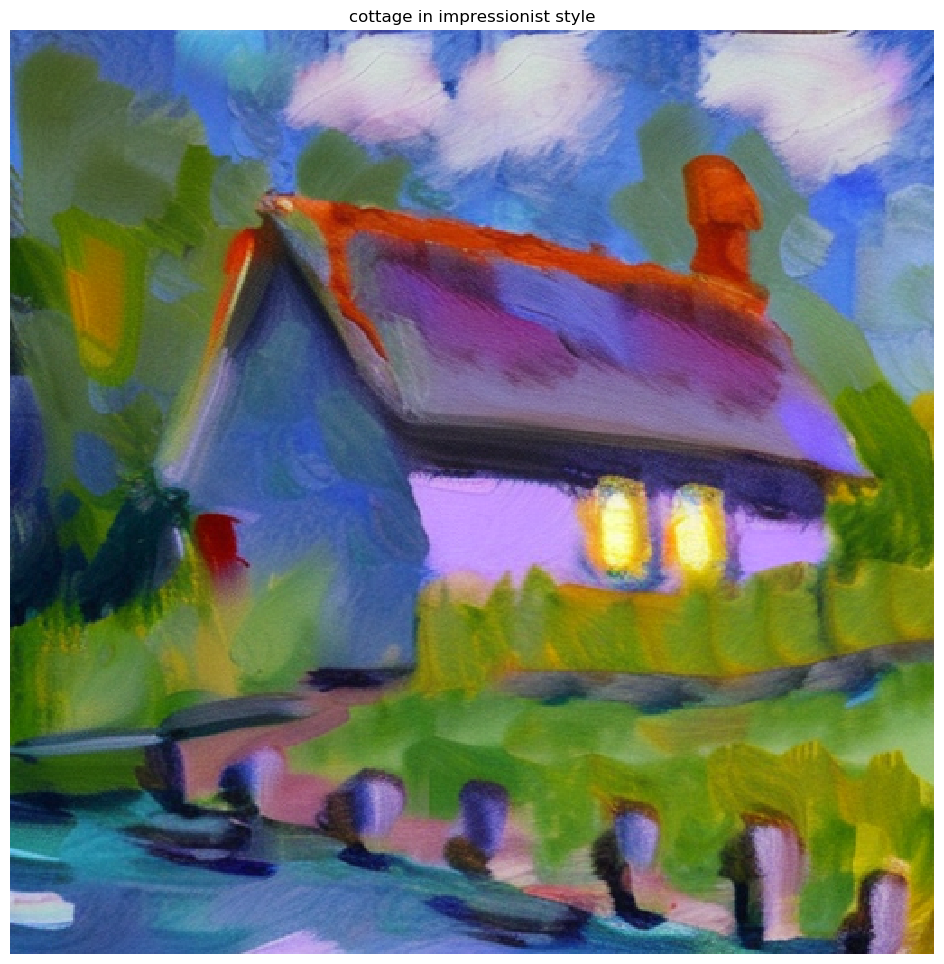

In [37]:
text = "cottage in impressionist style"
query_response = query(async_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

In [62]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{async_predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=5,
)

# response = asg_client.put_scaling_policy(
#     PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
#     ServiceNamespace="sagemaker",
#     ResourceId=resource_id,
#     ScalableDimension="sagemaker:variant:DesiredInstanceCount",
#     PolicyType="TargetTrackingScaling",
#     TargetTrackingScalingPolicyConfiguration={
#         "TargetValue": 1.0,
#         "CustomizedMetricSpecification": {
#             "MetricName": "ApproximateBacklogSizePerInstance",
#             "Namespace": "AWS/SageMaker",
#             "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
#             "Statistic": "Average",
#         },
#         "ScaleInCooldown": 300, # duration until scale in begins (down to zero)
#         "ScaleOutCooldown": 300 # duration between scale out attempts
#     },
# )


response = asg_client.put_scaling_policy(
    PolicyName = f'HasBacklogWithoutCapacity-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",  # The namespace of the service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="StepScaling",  # 'StepScaling' or 'TargetTrackingScaling'
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity", # Specifies whether the ScalingAdjustment value in the StepAdjustment property is an absolute number or a percentage of the current capacity. 
        "MetricAggregationType": "Average", # The aggregation type for the CloudWatch metrics.
        "Cooldown": 300, # The amount of time, in seconds, to wait for a previous scaling activity to take effect. 
        "StepAdjustments": # A set of adjustments that enable you to scale based on the size of the alarm breach.
        [ 
            {
              "MetricIntervalLowerBound": 0,
              "ScalingAdjustment": 1
            }
          ]
    },    
)

cw_client = boto3.client('cloudwatch')
step_scaling_policy_arn = response['PolicyARN']

response = cw_client.put_metric_alarm(
    AlarmName=f'step_scaling_policy_alarm_name-{async_predictor.endpoint_name}',
    MetricName='HasBacklogWithoutCapacity',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    EvaluationPeriods= 2,
    DatapointsToAlarm= 2,
    Threshold= 1,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name':'EndpointName', 'Value':async_predictor.endpoint_name },
    ],
    Period= 60,
    AlarmActions=[step_scaling_policy_arn]
)

In [ ]:
asg_client = boto3.client("application-autoscaling")
resource_id = f"endpoint/stablediffusion-txt2img-v2/variant/AllTraffic"
response_scalein = asg_client.put_scaling_policy(
    PolicyName = f'scaleinpolicy-stablediffusion-txt2img-v2',
    ServiceNamespace="sagemaker",  # The namespace of the service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="StepScaling",  # 'StepScaling' or 'TargetTrackingScaling'
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity", # Specifies whether the ScalingAdjustment value in the StepAdjustment property is an absolute number or a percentage of the current capacity. 
        "MetricAggregationType": "Average", # The aggregation type for the CloudWatch metrics.
        "Cooldown": 300, # The amount of time, in seconds, to wait for a previous scaling activity to take effect. 
        "StepAdjustments": # A set of adjustments that enable you to scale based on the size of the alarm breach.
        [ 
            {
              "MetricIntervalUpperBound": 0,
              "ScalingAdjustment": -1
            }
          ]
    },    
)

cw_client = boto3.client('cloudwatch')
stepin_scaling_policy_arn = response_scalein['PolicyARN']



In [69]:
response = cw_client.put_metric_alarm(
    AlarmName=f'step_scale-in_policy-{async_predictor.endpoint_name}',
    MetricName='ApproximateBacklogSizePerInstance',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    EvaluationPeriods= 2,
    DatapointsToAlarm= 2,
    Threshold= 0.5,
    ComparisonOperator='LessThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name':'EndpointName', 'Value':async_predictor.endpoint_name },
    ],
    Period= 60,
    AlarmActions=[stepin_scaling_policy_arn]
)

In [66]:
response = asg_client.delete_scaling_policy(PolicyName = f'HasBacklogWithoutCapacity-ScalingPolicy-{async_predictor.endpoint_name}',
                                            ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount")

In [87]:
import boto3
import json
from botocore.config import Config
# import numpy as np
# from PIL import Image
# from io import BytesIO
# import base64


def upload_to_s3(bucket_name, key, text):
    s3 = boto3.client('s3')
    response = s3.put_object(
        Bucket=bucket_name,
        Key=key,
        Body=text.encode('utf-8')
    )
    return response

endpoint_name = 'stablediffusion-txt2img-v2'
def query_endpoint_with_json_payload(encoded_json, bucket_name, key):

    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint_async(EndpointName=endpoint_name, ContentType='application/x-text',Accept = 'application/json', InputLocation=f's3://{bucket_name}/{key}')
    print(response)
    return response

def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]



payload = "cottage in impressionist style"

bucket_name = sess.default_bucket()
key = f'async_inference/{endpoint_name}/input/'
upload_to_s3(bucket_name, key, payload)

query_response = query_endpoint_with_json_payload(json.dumps(payload).encode('utf-8'),bucket_name, key)

output_location = query_response["OutputLocation"]
print(f"OutputLocation: {output_location}")




{'ResponseMetadata': {'RequestId': 'dabcdadd-21c1-4f2a-b2e7-bf9ae05f155c', 'HTTPStatusCode': 202, 'HTTPHeaders': {'x-amzn-requestid': 'dabcdadd-21c1-4f2a-b2e7-bf9ae05f155c', 'x-amzn-sagemaker-outputlocation': 's3://sagemaker-me-south-1-967062772751/async_inference/stablediffusion-txt2img-v2/output/d395f717-f676-4c11-b8e0-895c4daeedcf.out', 'x-amzn-sagemaker-failurelocation': 's3://sagemaker-me-south-1-967062772751/async-endpoint-failures/stablediffusion-txt2img-v2-1687410841-d852/d395f717-f676-4c11-b8e0-895c4daeedcf-error.out', 'date': 'Thu, 22 Jun 2023 12:29:55 GMT', 'content-type': 'application/json', 'content-length': '54', 'connection': 'keep-alive'}, 'RetryAttempts': 0}, 'OutputLocation': 's3://sagemaker-me-south-1-967062772751/async_inference/stablediffusion-txt2img-v2/output/d395f717-f676-4c11-b8e0-895c4daeedcf.out', 'FailureLocation': 's3://sagemaker-me-south-1-967062772751/async-endpoint-failures/stablediffusion-txt2img-v2-1687410841-d852/d395f717-f676-4c11-b8e0-895c4daeedcf-e

In [88]:
import urllib, time
from botocore.exceptions import ClientError
import sagemaker
sess = sagemaker.Session()


def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sess.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response["Error"]["Code"] == "NoSuchKey":
                print("waiting for output...")
                time.sleep(2)
                continue
            raise

In [ ]:
output = get_output(output_location)
print(f"Output: {output}")